# Módulo Multiprocessing

En estos apuntes se presentará muy brevemente como ejecutar código en paralelo empleando múltiples procesos.

In [1]:
from time import sleep, time

In [2]:
def delay(num):
    sleep(num)
    return num

Estas celdas sirven para realizar mediciones al vuelo de tiempo. Con la opción `-r` se indican la cantidad de repeticiones y con `-n` el número de interaciones por repetición.

In [3]:
%timeit -r 1 -n 10 delay(1)

1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [4]:
tic = time()
delay(1)
delay(1)
toc = time()
toc - tic

2.0036094188690186

In [5]:
from multiprocessing import Process

Para crear un proceso:

In [6]:
p1 = Process(target=delay,args=(1,))
p2 = Process(target=delay,args=(1,))

Los procesos han sido creados, pero no han sido ejecutados.

In [7]:
p1.start()
p2.start()

Para esperar a que los procesos terminen

In [8]:
p1.join()
p2.join()

Si se junta todo en una celda se puede observar el tiempo total

In [9]:
tic = time()
p1 = Process(target=delay,args=(5,))
p2 = Process(target=delay,args=(5,))
p1.start()
p2.start()
p1.join()
p2.join()
toc = time()
toc - tic

5.018382787704468

Ejecutar los dos procesos en simultáneo toma una cantidad cercana a 5 segundos, y ejecutar las funciones en serie hubiera tomado 10 segundos. Sin embargo, el código es poco escalable. ¿Qué pasaría si se quisiera emplear más de dos procesos en simultáneo? 

In [10]:
# lista de procesos
procs = []
# cantidad de procesos
cp = 4
# empezar a medir el tiempo
tic = time()
# crear una lista de procesos luego de iniciarlos
for _ in range(cp):
    p = Process(target=delay,args=(8,))
    p.start()
    procs.append(p)
# esperar a que terminen los procesos
for p in procs:
    p.join()
# terminar de medir el tiempo
toc = time()
# mostrar tiempo transcurrido
toc - tic

8.05596399307251

Ahora se puede definir una versión multriproceso para la función `delay`

In [11]:
def mpdelay(num,cp):
    procs = []
    
    for _ in range(cp):
        p = Process(target=delay,args=(num,))
        p.start()
        procs.append(p)

    for p in procs:
        p.join()
        
    return num

In [12]:
%timeit -r 1 -n 10 mpdelay(4,2)

4.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [13]:
%timeit -r 1 -n 10 mpdelay(4,4)

4.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [14]:
%timeit -r 1 -n 10 mpdelay(4,8)

4.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


Note que se tuvo que recurrir al uso de bucles `for` para poder desplegar varios procesos; sin embargo, esto ya no es necesario pues, el módulo `multiprocessing` proporciona la clase `Pool` la cual crea un objeto que ofrece un medio para paralelizar la ejecución de una función a través de múltiples valores de entrada, distribuyendo los datos de entrada entre los procesos.

In [15]:
from multiprocessing import Pool

¿Cómo se podrían desplegar varios procesos que duren una cierta cantidad de segundos sin usar los bucles for? Para esto existe el método `map` de la clase `Pool`.

In [16]:
def mpdelaymap(num,cp):
    p = Pool(cp)
    p.map(delay, [num]*cp)
    return num

In [17]:
%timeit -r 1 -n 10 mpdelaymap(4,2)

4.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [18]:
%timeit -r 1 -n 10 mpdelay(4,4)

4.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [19]:
%timeit -r 1 -n 10 mpdelay(4,8)

4.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


Ahora, ¿qué pasaría si la función no recibe un solo argumento? Para estos casos, la clase `Pool` ofrece el método `starmap`.

In [20]:
def xydelay(x,y):
    sleep(x)
    sleep(y)

Ahora hay que definir una versión que permita ejecutar multiples procesos con esta función

In [21]:
def mpxydelay(xs, ys, cp):
    p = Pool(cp)
    p.starmap(xydelay, zip(xs, ys))

Se realizarán pruebas con números aleatorios entre 1 y 5:

In [22]:
import random
cp = 8

In [23]:
xs = [random.randint(1,5) for _ in range(cp)]
xs

[2, 3, 5, 3, 5, 4, 5, 3]

In [24]:
ys = [random.randint(1,5) for _ in range(cp)]
ys

[2, 5, 4, 1, 2, 5, 3, 5]

In [25]:
tic = time()
mpxydelay(xs, ys, cp)
toc = time()
toc - tic

9.036815166473389

Note que lanzar 8 procesos tomó solo el tiempo de mayor par (x, y). En este caso, fueron nueve segundos.

## Caso Factorial

In [26]:
def factorial(n):
    f = 1
    for x in range(1,n+1):
        f *= x
    return f

El factorial es una multiplicación de una secuencia de números, para optimizar su tiempo de ejecución usando múltiples procesos se puede dividir esa secuencia en pequeñas subsecuencias y luego multiplicar esos resultados parciales. Para esto vamos a crear dos funciones auxiliares; una para multiplicar una secuencia de números, y otra para multiplicar los elementos de una lista de números no necesariamente secuenciales.

In [27]:
def prodseq(start,stop):
    p = start
    for n in range(start+1,stop+1):
        p *= n
    return p

In [28]:
def prodlist(nums):
    p = 1
    for num in nums:
        p *= num
    return p

In [29]:
def mpfactorial(n,cp):
    # se le indica la cantidad de procesos y se crea el objeto
    p = Pool(cp)
    l1 = [((x*n)//cp)+1 for x in range(cp)]
    l2 = [((x*n)//cp) for x in range(1,cp+1)]
    rp = p.starmap(prodseq, zip(l1,l2))
    p.close()
    p.join()
    return prodlist(rp)

Se realiza una prueba numérica para verificar que el valor es correcto

In [30]:
n = 100000
mpfactorial(n,2) == mpfactorial(n,4) == mpfactorial(n,8) == factorial(n)

True

Podemos realizar una prueba de tiempo al vuelo para tener una idea de como serán los tiempos de ejecución.

In [31]:
%timeit -r 2 -n 10 factorial(n)

1.7 s ± 22.4 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [32]:
%timeit -r 2 -n 10 mpfactorial(n,2)

529 ms ± 1.88 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [33]:
%timeit -r 2 -n 10 mpfactorial(n,4)

238 ms ± 5.86 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [34]:
%timeit -r 2 -n 10 mpfactorial(n,8)

225 ms ± 1.84 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


## Pruebas

In [35]:
import statistics

def filtro_mediana(sign, w):
    signc = []
    lc = sign+sign+sign
    ii = len(sign)
    for i in range(len(sign)):
        izq = i + ii - w//2
        der = i + ii + w//2
        signc.append(statistics.median(lc[izq:der+1]))
    return signc

In [36]:
from statistics import mean

In [37]:
import matplotlib.pyplot as plt

In [38]:
start = 10000
stop = 100000 + start
step = start
tams = range(start,stop,step)
veces = range(20)

In [39]:
ls = []
lmp2 = []
lmp4 = []
lmp8 = []
for tam in tams:
    lsi = []
    lmp2i = []
    lmp4i = []
    lmp8i = []
    for _ in veces:
        tic = time()
        rs = factorial(tam)
        toc = time()
        lsi.append(toc-tic)
        
        tic = time()
        rmp2 = mpfactorial(tam,2)
        toc = time()
        lmp2i.append(toc-tic)
        
        tic = time()
        rmp4 = mpfactorial(tam,4)
        toc = time()
        lmp4i.append(toc-tic)
        
        tic = time()
        rmp8 = mpfactorial(tam,8)
        toc = time()
        lmp8i.append(toc-tic)
        
    ls.append(mean(filtro_mediana(lsi,7)))
    lmp2.append(mean(filtro_mediana(lmp2i,7)))
    lmp4.append(mean(filtro_mediana(lmp4i,7)))
    lmp8.append(mean(filtro_mediana(lmp8i,7)))

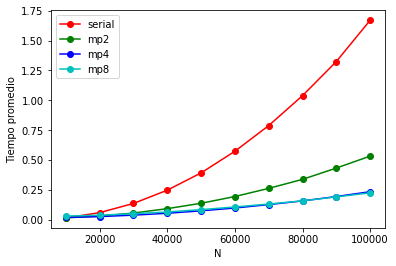

In [40]:
plt.plot(tams,ls,'r-o',label='serial')
plt.plot(tams,lmp2,'g-o',label='mp2')
plt.plot(tams,lmp4,'b-o',label='mp4')
plt.plot(tams,lmp8,'c-o',label='mp8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

En general, la gráfica muestra un comportamiento esperado; sin embargo, el primer caso no se aprecia bien. Para esto se realizará un acercamiento.

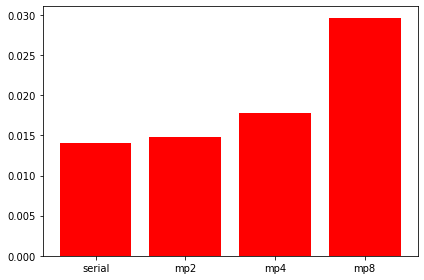

In [41]:
noms = ['serial','mp2','mp4','mp8']
proms1 = [ls[0], lmp2[0], lmp4[0], lmp8[0]]
plt.bar(noms,proms1,color='r')
plt.tight_layout()

Se observa que para el primer caso todas las formas con múltiples procesos presentaron tiempos mayores a la forma serial, y luego recién a partir del segundo tamagno se empieza a observar ganancia, pero tampoco se aprecia con claridad.

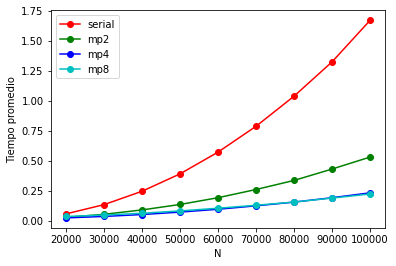

In [42]:
plt.plot(tams[1:],ls[1:],'r-o',label='serial')
plt.plot(tams[1:],lmp2[1:],'g-o',label='mp2')
plt.plot(tams[1:],lmp4[1:],'b-o',label='mp4')
plt.plot(tams[1:],lmp8[1:],'c-o',label='mp8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

¿Qué ocurre en el segundo tamaño? 

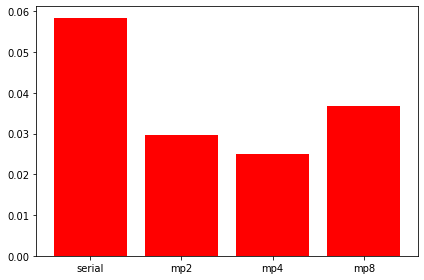

In [43]:
noms = ['serial','mp2','mp4','mp8']
proms1 = [ls[1], lmp2[1], lmp4[1], lmp8[1]]
plt.bar(noms,proms1,color='r')
plt.tight_layout()

Note que para el segundo tamaño todos las formas con `multiprocessing` demoran menos que la forma serial, pero con 8 núcleos ha demorado más que con 4 núcleos. ¿Cuál podría ser el problema?

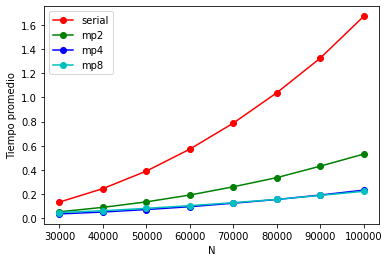

In [44]:
plt.plot(tams[2:],ls[2:],'r-o',label='serial')
plt.plot(tams[2:],lmp2[2:],'g-o',label='mp2')
plt.plot(tams[2:],lmp4[2:],'b-o',label='mp4')
plt.plot(tams[2:],lmp8[2:],'c-o',label='mp8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

No se aprecia la diferencia de tiempos entre la función que usa cuatro procesos y la que usa ocho procesos. Quizás sería mejor graficar esas dos curvas de forma aislada.

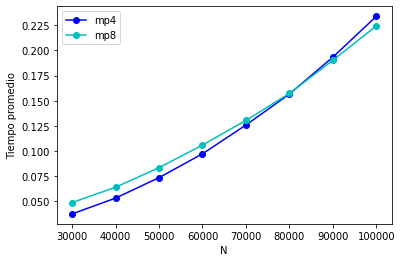

In [45]:
plt.plot(tams[2:],lmp4[2:],'b-o',label='mp4')
plt.plot(tams[2:],lmp8[2:],'c-o',label='mp8')
plt.xlabel('N')
plt.ylabel('Tiempo promedio')
plt.legend()

Se ve que usar ocho procesos solo redujo el tiempo de ejecución en los dos últimos tamaños y tampoco fue por tanta diferencia.

In [46]:
from numpy import asarray

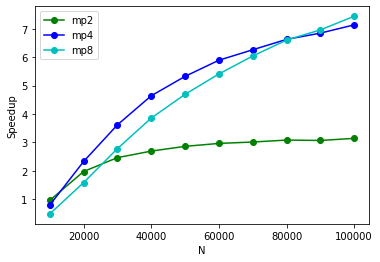

In [47]:
plt.plot(tams,asarray(ls)/asarray(lmp2),'g-o',label='mp2')
plt.plot(tams,asarray(ls)/asarray(lmp4),'b-o',label='mp4')
plt.plot(tams,asarray(ls)/asarray(lmp8),'c-o',label='mp8')
plt.xlabel('N')
plt.ylabel('Speedup')
plt.legend()

En línea con las observaciones anteriores, en el primer caso, la gráfica muestra que todos presentan pérdidas en tiempo de ejecución, y a partir del segundo caso todos presentan ganancia.

Como comentario, solo mencionar que el uso de múltiples procesos se recomienda solo en casos de una aplicación que esté limitada por CPU, y que requiera mucha computación. Por otro lado, la cantidad de procesos que puede lanzar no está limitada, pero se recomienda que no exceda a la cantidad de núcleos que posee su ordenador.

Se recomienda al lector realizar mediciones con una cantidad de procesos mayor a la cantidad de CPUs y comentar las observaciones.